# Test on real world data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from torchvision.io import read_image, ImageReadMode

from helper import *

In [2]:
dir = "data_pngs"
subjects = {}
for subject in sorted(os.listdir(dir)):
    for pic in sorted(os.listdir(os.path.join(dir, subject))):
        f = os.path.join(dir, subject, pic)
        img = read_image(f, ImageReadMode.GRAY)
        img = torchvision.transforms.ConvertImageDtype(torch.float64)(img)
        img = torch.flatten(img.squeeze().T)
        if subjects.get(subject) == None:
            subjects[subject] = img
        else:
            subjects[subject] = torch.column_stack((subjects[subject], img))

## functions

In [3]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, d1, d2):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(1/(2 * np.power(d1 * d2, 1/4))))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

In [4]:
def get_net_outputs(net_trained, net_bftrain, r, dataset):
    out_bftrain = []
    out_hat = []
    for i in range(len(dataset)):
        M_true = dataset[i]
        L_bftrain, S_bftrain = net_bftrain(M_true, r)
        out_bftrain.append((L_bftrain.detach().numpy(), S_bftrain.detach().numpy()))
        L_hat, S_hat = net_trained(M_true, r)
        out_hat.append((L_hat.detach().numpy(), S_hat.detach().numpy()))
    out_bftrain = np.asarray(out_bftrain)
    out_hat = np.asarray(out_hat)
    return out_bftrain, out_hat

In [6]:
def plot_true_vs_est_matrices(L_hat, L_true, S_hat, S_true):
    combined = np.concatenate((L_hat, L_true, S_hat, S_true))
    plt.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    plt.show()
    plt.imshow(L_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    plt.show()
    plt.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    plt.show()
    plt.imshow(S_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    plt.show()

## Training

In [7]:
r = 1
max_iter = 50

In [8]:
print("original beta =", 1/(2 * np.power(243 * 320 * 11, 1/4)))

original beta = 0.01644117189829903


In [9]:
train = [subjects[x] for x in ['subject01', 'subject02', 'subject03', 'subject04', 'subject05', 'subject06', 'subject07']]
test = [subjects[x] for x in ['subject08', 'subject09', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15']]
train_est = []
for i, M_true in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))
    print(loss[-1])

tensor(8.9505e-07, dtype=torch.float64)
tensor(2.7088e-07, dtype=torch.float64)
tensor(7.4708e-07, dtype=torch.float64)
tensor(8.9582e-07, dtype=torch.float64)
tensor(8.5935e-07, dtype=torch.float64)
tensor(7.9685e-07, dtype=torch.float64)
tensor(7.2885e-07, dtype=torch.float64)


In [25]:
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter, 243 * 320, 11), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

[Parameter containing:
tensor(0.6998, requires_grad=True), Parameter containing:
tensor(0.0162, dtype=torch.float64, requires_grad=True)]
tensor(0.1321) tensor(0.4300, dtype=torch.float64)
Epoch 1/8 at cost=0.037547545128677105
[Parameter containing:
tensor(0.6999, requires_grad=True), Parameter containing:
tensor(0.0164, dtype=torch.float64, requires_grad=True)]
tensor(-0.2797) tensor(-1.9222, dtype=torch.float64)
Epoch 1/8 at cost=0.03739752107199634
[Parameter containing:
tensor(0.6998, requires_grad=True), Parameter containing:
tensor(0.0162, dtype=torch.float64, requires_grad=True)]
tensor(10.3548) tensor(40.8792, dtype=torch.float64)
Epoch 1/8 at cost=0.8969047195421153
[Parameter containing:
tensor(0.6996, requires_grad=True), Parameter containing:
tensor(0.0161, dtype=torch.float64, requires_grad=True)]
tensor(0.6828) tensor(2.6274, dtype=torch.float64)
Epoch 1/8 at cost=0.07545619268295829
[Parameter containing:
tensor(0.6995, requires_grad=True), Parameter containing:
tensor(

## on train data

In [26]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter, 243 * 320, 11), r, train)

In [27]:
out_hat[0][0].shape

(77760, 11)

In [28]:
out_accaltproj = []
for i, M_true in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    print(loss[-1])
    out_accaltproj.append((L0, S0, M_true))

tensor(8.7872e-07, dtype=torch.float64)
tensor(8.9039e-07, dtype=torch.float64)
tensor(8.7484e-07, dtype=torch.float64)
tensor(7.3572e-07, dtype=torch.float64)
tensor(8.1900e-07, dtype=torch.float64)
tensor(8.5820e-07, dtype=torch.float64)
tensor(7.7940e-07, dtype=torch.float64)


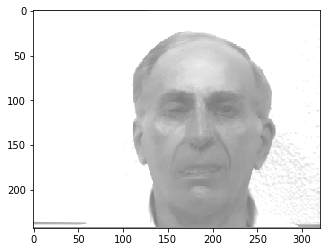

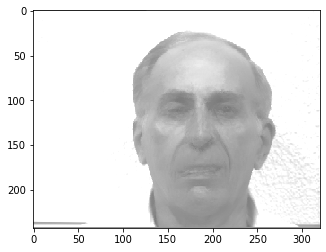

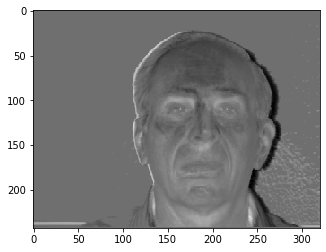

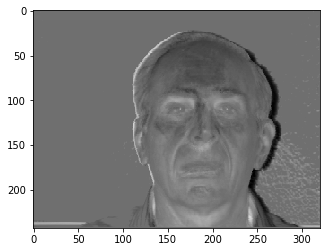

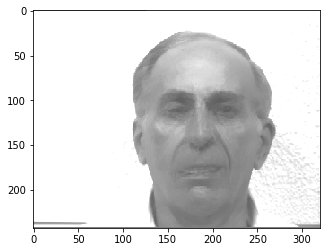

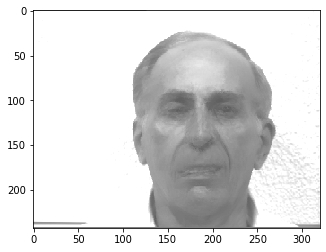

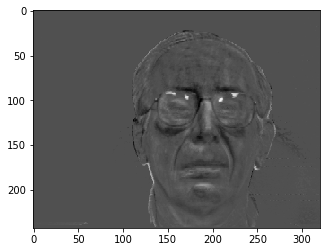

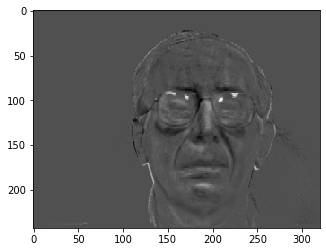

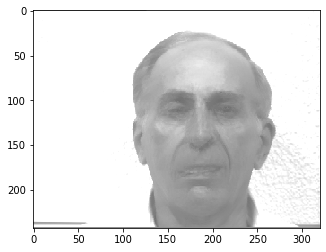

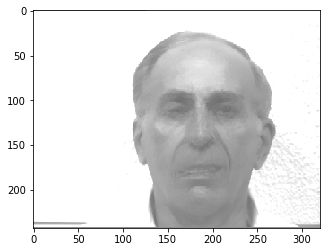

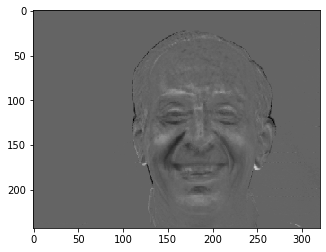

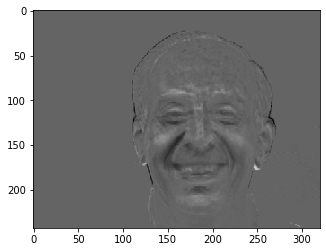

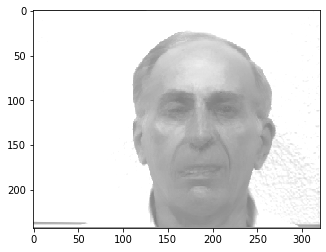

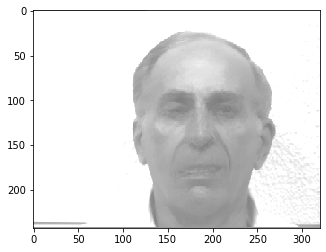

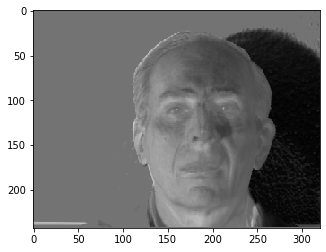

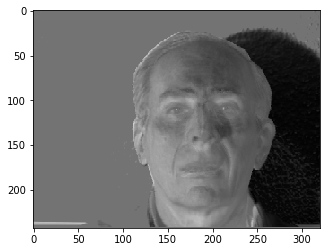

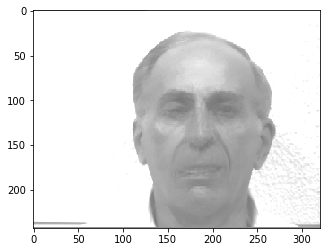

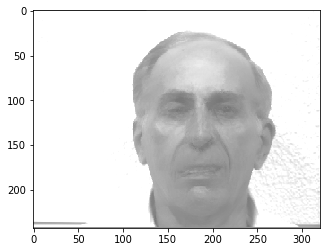

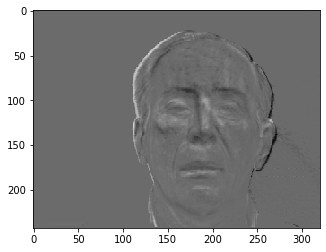

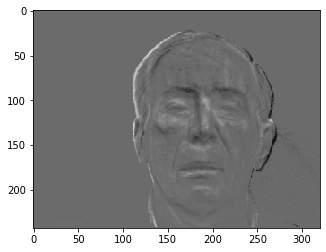

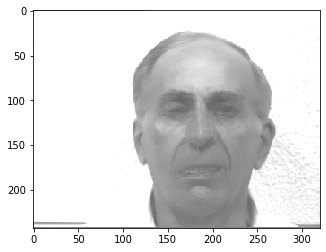

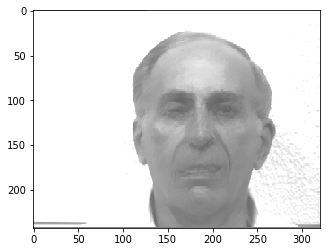

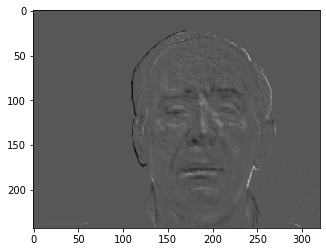

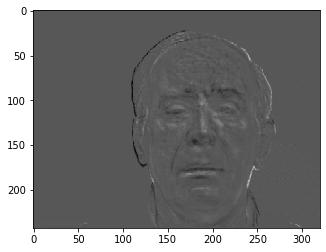

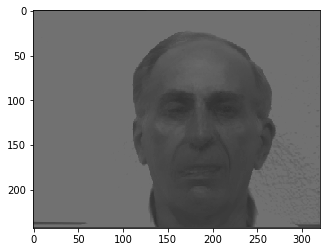

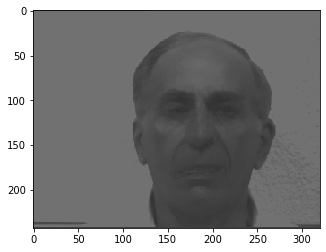

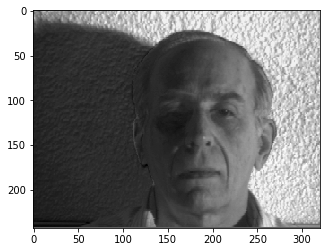

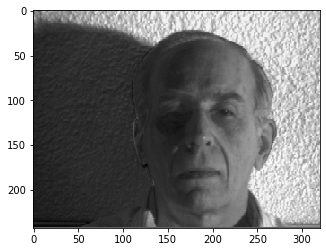

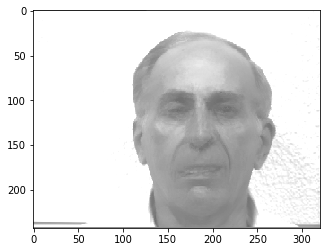

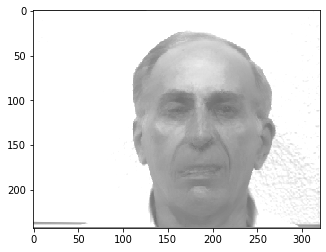

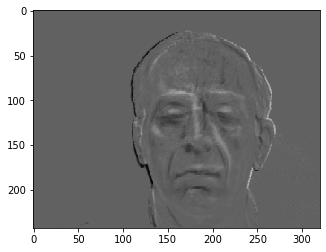

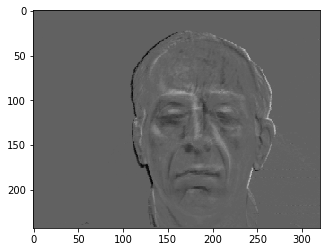

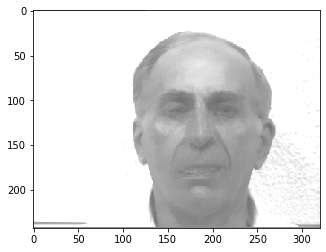

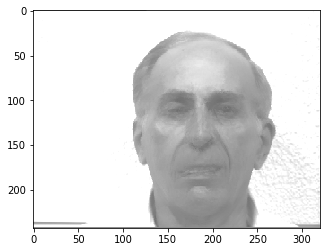

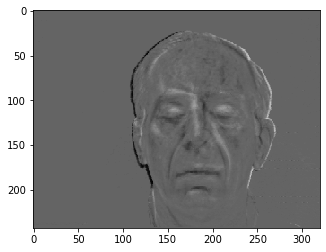

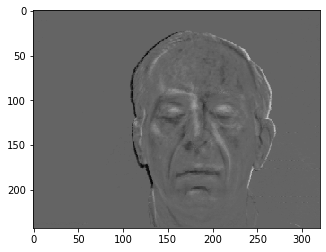

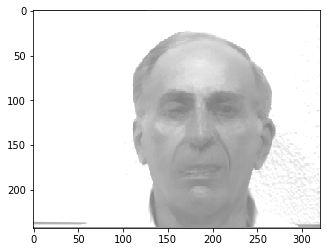

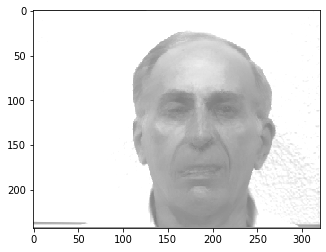

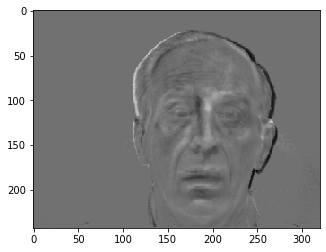

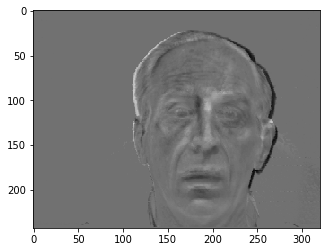

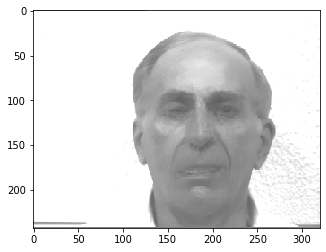

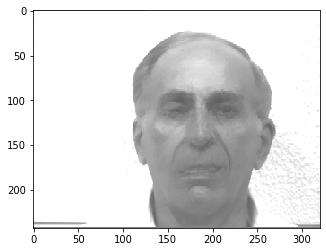

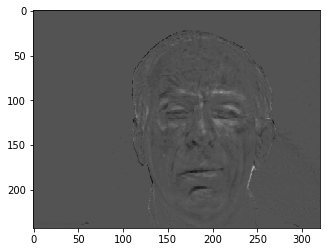

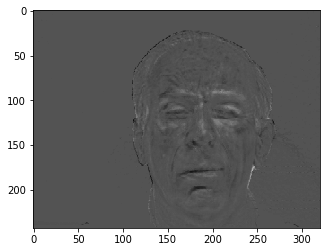

In [29]:
subject1_train_est = train_est[4]
subject1_out_hat = out_hat[4]
subject1_out_bftrain = out_bftrain[4]
subject1_out_accaltproj = out_accaltproj[4]

lowrank_train_est = subject1_train_est[0]
lowrank_out_hat = subject1_out_hat[0]
lowrank_out_bftrain = subject1_out_bftrain[0]
lowrank_out_accaltproj = subject1_out_accaltproj[0]

sparse_train_est = subject1_train_est[1]
sparse_out_hat = subject1_out_hat[1]
sparse_out_bftrain = subject1_out_bftrain[1]
sparse_out_accaltproj = subject1_out_accaltproj[1]
for i in range(11):
    plot_true_vs_est_matrices((lowrank_out_hat[:,i].reshape(320, 243).T) \
                            , (lowrank_out_accaltproj[:,i].reshape(320, 243).T) \
                            , (sparse_out_hat[:,i].reshape(320, 243).T) \
                            , (sparse_out_accaltproj[:,i].reshape(320, 243).T))

## on test data

In [30]:
print(list(net.parameters()))

[Parameter containing:
tensor(0.6993, requires_grad=True), Parameter containing:
tensor(0.0162, dtype=torch.float64, requires_grad=True)]


In [31]:
out_accaltproj_ontest = []
out_ircur_ontest = []
for i, M_true in enumerate(test):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    print(loss[-1])
    out_accaltproj_ontest.append((L0, S0, M_true))
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest.append((L0, S0, M_true))

tensor(8.9461e-07, dtype=torch.float64)
tensor(7.6016e-07, dtype=torch.float64)
tensor(7.8150e-07, dtype=torch.float64)
tensor(8.8878e-07, dtype=torch.float64)
tensor(8.0249e-07, dtype=torch.float64)
tensor(9.2261e-07, dtype=torch.float64)
tensor(8.7332e-07, dtype=torch.float64)
tensor(8.7300e-07, dtype=torch.float64)


In [32]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter, 243 * 320, 11), r, test)

In [33]:
subject1_accaltproj_ontest = out_accaltproj_ontest[5]
subject1_ircur_ontest = out_ircur_ontest[5]
subject1_out_hat_ontest = out_hat_ontest[5]
subject1_out_bftrain_ontest = out_bftrain_ontest[5]
lowrank_accaltproj_ontest = subject1_accaltproj_ontest[0]
lowrank_ircur_ontest = subject1_ircur_ontest[0]
lowrank_out_hat_ontest = subject1_out_hat_ontest[0]
lowrank_out_bftrain_ontest = subject1_out_bftrain_ontest[0]
sparse_accaltproj_ontest = subject1_accaltproj_ontest[1]
sparse_ircur_ontest = subject1_ircur_ontest[1]
sparse_out_hat_ontest = subject1_out_hat_ontest[1]
sparse_out_bftrain_ontest = subject1_out_bftrain_ontest[1]
# for i in range(11):
#     plot_true_vs_est_matrices((lowrank_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
#                             , (lowrank_ircur_ontest[:,i].reshape(320, 243).T * 255) \
#                             , (sparse_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
#                             , (sparse_ircur_ontest[:,i].reshape(320, 243).T * 255))

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f887b2b7d90>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f888104dca0>)

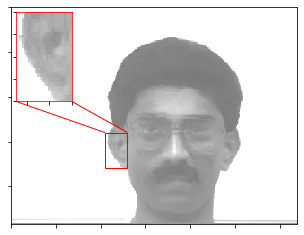

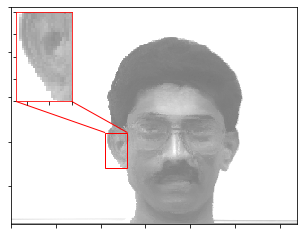

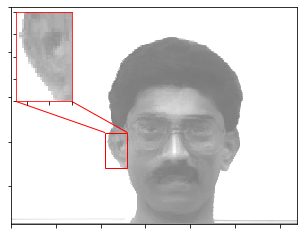

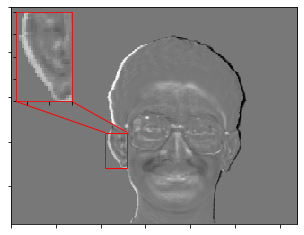

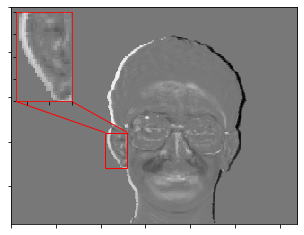

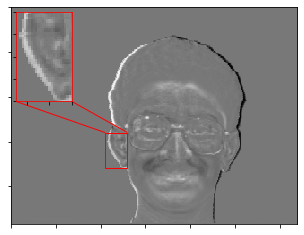

In [34]:
L_hat = (lowrank_out_hat_ontest[:,2].reshape(320, 243).T * 255)
S_hat = (sparse_out_hat_ontest[:,2].reshape(320, 243).T * 255)
L_ircur = (lowrank_ircur_ontest[:,2].reshape(320, 243).T * 255)
S_ircur = (sparse_ircur_ontest[:,2].reshape(320, 243).T * 255)
L_accaltproj = (lowrank_accaltproj_ontest[:,2].reshape(320, 243).T * 255)
S_accaltproj = (sparse_accaltproj_ontest[:,2].reshape(320, 243).T * 255)


combined = np.concatenate((L_hat, L_ircur, L_accaltproj, S_hat, S_ircur, S_accaltproj))

#where to zoom ?
x1=105
x2=130
y1=140
y2=180


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_unrolled_lr.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_ircur_lr.eps', format='eps')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_accaltproj_lr.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_unrolled_s_happy.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_ircur_s_happy.eps', format='eps')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_13_accaltproj_s_happy.eps', format='eps')

In [35]:
subject1_accaltproj_ontest = out_accaltproj_ontest[2]
subject1_ircur_ontest = out_ircur_ontest[2]
subject1_out_hat_ontest = out_hat_ontest[2]
subject1_out_bftrain_ontest = out_bftrain_ontest[2]
lowrank_accaltproj_ontest = subject1_accaltproj_ontest[0]
lowrank_ircur_ontest = subject1_ircur_ontest[0]
lowrank_out_hat_ontest = subject1_out_hat_ontest[0]
lowrank_out_bftrain_ontest = subject1_out_bftrain_ontest[0]
sparse_accaltproj_ontest = subject1_accaltproj_ontest[1]
sparse_ircur_ontest = subject1_ircur_ontest[1]
sparse_out_hat_ontest = subject1_out_hat_ontest[1]
sparse_out_bftrain_ontest = subject1_out_bftrain_ontest[1]

In [36]:
L_hat = (lowrank_out_hat_ontest[:,2].reshape(320, 243).T * 255)
S_hat = (sparse_out_hat_ontest[:,2].reshape(320, 243).T * 255)
L_ircur = (lowrank_ircur_ontest[:,2].reshape(320, 243).T * 255)
S_ircur = (sparse_ircur_ontest[:,2].reshape(320, 243).T * 255)
L_accaltproj = (lowrank_accaltproj_ontest[:,2].reshape(320, 243).T * 255)
S_accaltproj = (sparse_accaltproj_ontest[:,2].reshape(320, 243).T * 255)

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f887b261370>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f887b24f2b0>)

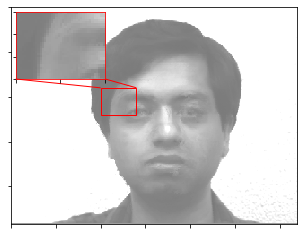

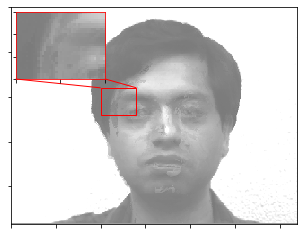

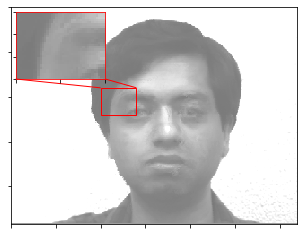

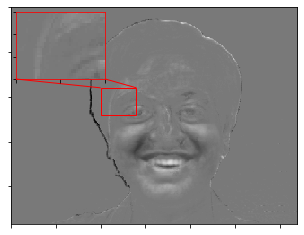

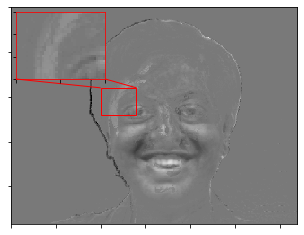

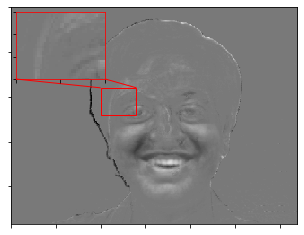

In [37]:
combined = np.concatenate((L_hat, L_ircur, L_accaltproj, S_hat, S_ircur, S_accaltproj))

#where to zoom ?
x1=100
x2=140
y1=90
y2=120

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_unrolled_lr.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_ircur_lr.eps', format='eps')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(L_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(L_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_accaltproj_lr.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_unrolled_s_happy.eps', format='eps')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_ircur_s_happy.eps', format='eps')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.xticks(visible=False)
plt.yticks(visible=False)
axins = zoomed_inset_axes(ax, 2.5, loc=2)
axins.imshow(S_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_color('r')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.invert_yaxis() 
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec='r')
# plt.savefig('plots/subject_10_accaltproj_s_happy.eps', format='eps')
